<a href="https://colab.research.google.com/github/nhanphm/embryos/blob/main/U_net_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os

os.chdir('/content/')

In [4]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [5]:
import os
import datetime
import glob
import random
import sys

import matplotlib.pyplot as plt
import skimage.io                                     #Used for imshow function
import skimage.transform                              #Used for resize function
from skimage.morphology import label                  #Used for Run-Length-Encoding RLE to create final submission

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.optimizers import Adam

INPUT_SHAPE = 256
OUTPUT_SHAPE = 256
img_height = INPUT_SHAPE
img_width = OUTPUT_SHAPE

import random
seed = 42
random.seed = seed
np.random.seed(seed=seed)
from tensorflow import set_random_seed
set_random_seed(seed)

In [6]:
from sklearn.model_selection import train_test_split
import glob2

test_image_paths = glob2.glob('/content/drive/MyDrive/LuanVan_Embryos_segment/Unet/embryos-622/test/image/*.png')
test_label_paths = ['/content/drive/MyDrive/LuanVan_Embryos_segment/Unet/embryos-622/test/label/' + path.split('/')[-1] for path in test_image_paths]

In [7]:
import skimage.io                                     #Used for imshow function
import skimage.transform                              #Used for resize function
from skimage.morphology import label                  #Used for Run-Length-Encoding RLE to creat
from skimage.util import img_as_ubyte
# Get testing data
def get_X_data(path, output_shape=(None, None)):
    '''
    Loads images from path/{id}/images/{id}.png into a numpy array
    '''
    img_paths = path
    X_data = np.array([img_as_ubyte(skimage.transform.resize(skimage.io.imread(path, as_gray=True), output_shape=output_shape+(1,), mode='constant', preserve_range=True)) for path in img_paths])  #take only 3 channels/bands
    
    return X_data

# Get testing data labels
def get_Y_data(path, output_shape=(None, None)):
    '''
    Loads and concatenates images from path/{id}/masks/{id}.png into a numpy array
    '''
    img_paths = path
    
    Y_data = []
    for i, img_masks in enumerate(img_paths):  #loop through each individual nuclei for an image and combine them together
        masks = skimage.io.imread_collection(img_masks).concatenate()  #masks.shape = (num_masks, img_height, img_width)
        mask = np.max(masks, axis=0)                                   #mask.shape = (img_height, img_width)
        mask = skimage.transform.resize(mask, output_shape=output_shape+(1,), mode='constant', preserve_range=True)  #need to add an extra dimension so mask.shape = (img_height, img_width, 1)
        Y_data.append(mask)
    Y_data = np.array(Y_data, dtype=np.bool)
    
    return Y_data

X_testz = get_X_data(test_image_paths, output_shape=(img_height,img_width))
print(X_testz.shape, X_testz.dtype)
Y_testz = get_Y_data(test_label_paths, output_shape=(img_height,img_width))
print(Y_testz.shape, Y_testz.dtype)


(105, 256, 256, 1) uint8
(105, 256, 256, 1) bool


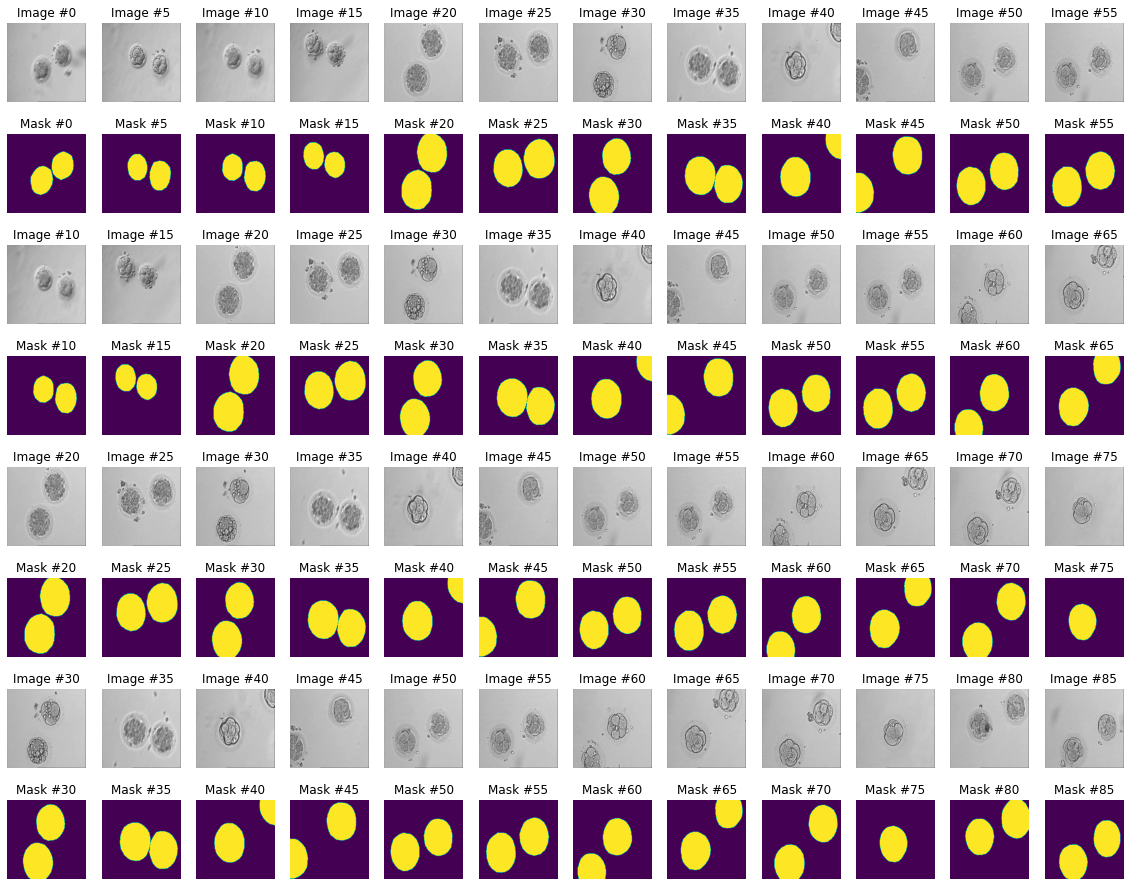

In [8]:
# Illustrate the train images and masks
plt.figure(figsize=(20,16))
x, y = 12,4
for i in range(y):  
    for j in range(x):
        # train image
        plt.subplot(y*2, x, i*2*x+j+1)
        pos = i*10 + j*5
        plt.imshow(np.squeeze(X_testz[pos]), cmap='gray', vmin=0, vmax=255)
        plt.title('Image #{}'.format(pos))
        plt.axis('off')
        plt.subplot(y*2, x, (i*2+1)*x+j+1)
        plt.imshow(np.squeeze(Y_testz[pos]))
        plt.title('Mask #{}'.format(pos))
        plt.axis('off')
#plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

In [9]:
# Design our model architecture here
def keras_model(img_width=OUTPUT_SHAPE, img_height=OUTPUT_SHAPE):
    '''
    Modified from https://keunwoochoi.wordpress.com/2017/10/11/u-net-on-keras-2-0/
    '''
    n_ch_exps = [4, 5, 6, 7, 8, 9]   #the n-th deep channel's exponent i.e. 2**n 16,32,64,128,256
    k_size = (3, 3)                  #size of filter kernel
    k_init = 'he_normal'             #kernel initializer

    if K.image_data_format() == 'channels_first':
        ch_axis = 1
        input_shape = (1, img_width, img_height)
    elif K.image_data_format() == 'channels_last':
        ch_axis = 3
        input_shape = (img_width, img_height, 1)

    inp = Input(shape=input_shape)
    encodeds = []

    # encoder
    enc = inp
    print(n_ch_exps)
    for l_idx, n_ch in enumerate(n_ch_exps):
        enc = Conv2D(filters=2**n_ch, kernel_size=k_size, activation='relu', padding='same', kernel_initializer=k_init)(enc)
        enc = Dropout(0.1*l_idx,)(enc)
        enc = Conv2D(filters=2**n_ch, kernel_size=k_size, activation='relu', padding='same', kernel_initializer=k_init)(enc)
        encodeds.append(enc)
        #print(l_idx, enc)
        if n_ch < n_ch_exps[-1]:  #do not run max pooling on the last encoding/downsampling step
            enc = MaxPooling2D(pool_size=(2,2))(enc)
    
    # decoder
    dec = enc
    print(n_ch_exps[::-1][1:])
    decoder_n_chs = n_ch_exps[::-1][1:]
    for l_idx, n_ch in enumerate(decoder_n_chs):
        l_idx_rev = len(n_ch_exps) - l_idx - 2  #
        dec = Conv2DTranspose(filters=2**n_ch, kernel_size=k_size, strides=(2,2), activation='relu', padding='same', kernel_initializer=k_init)(dec)
        dec = concatenate([dec, encodeds[l_idx_rev]], axis=ch_axis)
        dec = Conv2D(filters=2**n_ch, kernel_size=k_size, activation='relu', padding='same', kernel_initializer=k_init)(dec)
        dec = Dropout(0.1*l_idx)(dec)
        dec = Conv2D(filters=2**n_ch, kernel_size=k_size, activation='relu', padding='same', kernel_initializer=k_init)(dec)

    outp = Conv2DTranspose(filters=1, kernel_size=k_size, activation='sigmoid', padding='same', kernel_initializer='glorot_normal')(dec)

    model = Model(inputs=[inp], outputs=[outp])
    
    return model

In [42]:
# Custom IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)
    
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [43]:
# Custom loss function
from keras.losses import binary_crossentropy
import keras.backend as K


def dice_coeff(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score


def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss


def bce_dice_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss


In [17]:
import keras
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Conv2DTranspose
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.models import load_model, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.merge import add, concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import plot_model
from keras import backend as K
import tensorflow as tf
import sklearn
from sklearn.model_selection import train_test_split

# Set some model compile parameters
optimizer = 'adam'
loss      = bce_dice_loss
metrics   = [mean_iou, f1_m, precision_m, recall_m]

# Compile our model
model = keras_model(img_width=img_width, img_height=img_height)
model.summary()


model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

[4, 5, 6, 7, 8, 9]
[8, 7, 6, 5, 4]
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_67 (Conv2D)              (None, 256, 256, 16) 160         input_4[0][0]                    
__________________________________________________________________________________________________
dropout_34 (Dropout)            (None, 256, 256, 16) 0           conv2d_67[0][0]                  
__________________________________________________________________________________________________
conv2d_68 (Conv2D)              (None, 256, 256, 16) 2320        dropout_34[0][0]                 
_________________________________________________________

In [18]:
# Reload the model
#from tensorflow import keras
#model = keras.models.load_model('/content/drive/MyDrive/LuanVan_Embryos_segment/Unet/mymodel')

model = keras_model(img_width=img_width, img_height=img_height)
model.load_weights("/content/drive/MyDrive/LuanVan_Embryos_segment/Unet/model-weights.h5")

[4, 5, 6, 7, 8, 9]
[8, 7, 6, 5, 4]


In [20]:
# Predict on test
preds_test = model.predict(X_testz, verbose=1)
# Threshold predictions
#preds_test_t = (preds_test > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5)


105/105 [==============================] - 10s 94ms/step


In [21]:
def cal_iou(A, B):
    intersection = np.logical_and(A, B)
    union = np.logical_or(A, B)
    iou = np.sum(intersection > 0) / np.sum(union > 0)
    return iou

In [22]:
# calcualte average iou of validation images, the result from tensorflow seems too high. 
iou=[]
#f1=[]
for i in range(len(Y_testz)):
    iou.append(cal_iou(np.squeeze(Y_testz[i]), np.squeeze(preds_test_t[i])))
print('Average Validate IOU: {}'.format(round(np.mean(iou),2)))

Average Validate IOU: 0.92


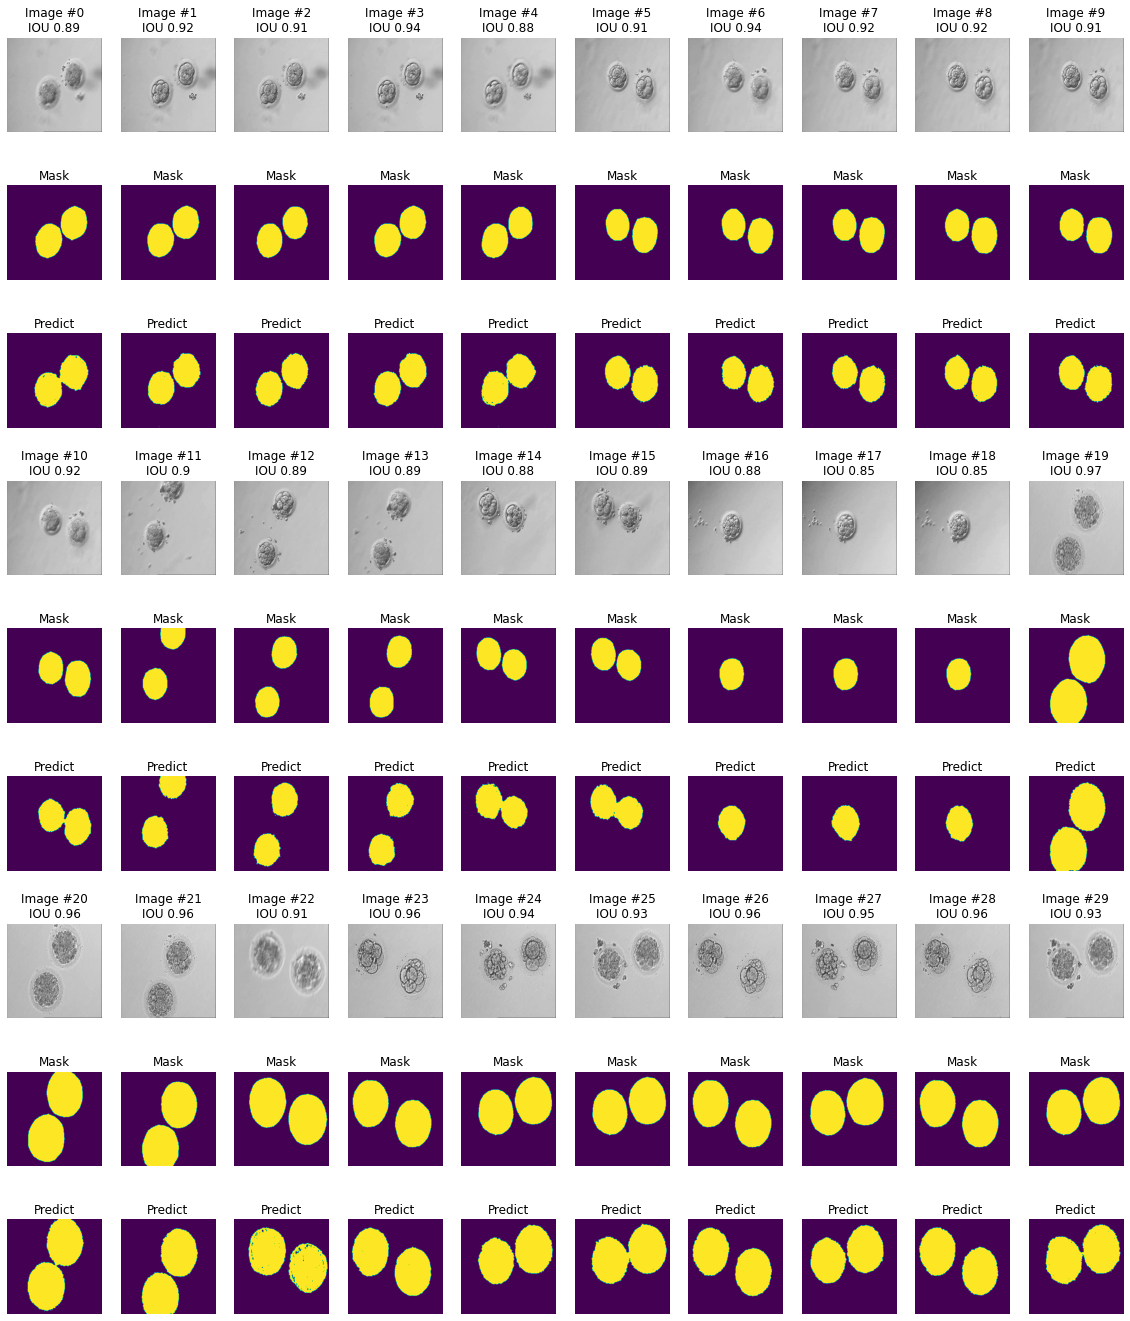

In [24]:
#plt.figure(figsize=(20,10.5))
plt.figure(figsize=(20,24))
x, y = 10,3
for i in range(y):  
    for j in range(x):
        # train image
        plt.subplot(y*3, x, i*3*x+j+1)
        pos = i*x+j
        plt.imshow(np.squeeze(X_testz[pos]), cmap='gray', vmin=0, vmax=255)
        plt.title('Image #{}\nIOU {}'.format(pos,round(cal_iou(np.squeeze(Y_testz[pos]), np.squeeze(preds_test_t[pos])),2)))
        plt.axis('off')
        plt.subplot(y*3, x, (i*3+1)*x+j+1)
        plt.imshow(np.squeeze(Y_testz[pos]))
        plt.title('Mask')
        plt.axis('off')
        plt.subplot(y*3, x, (i*3+2)*x+j+1)
        plt.imshow(np.squeeze(preds_test_t[pos]))
        plt.title('Predict')
        plt.axis('off')
plt.show()

In [45]:
from tensorflow import keras
# Set some model compile parameters
optimizer = 'adam'
loss      = bce_dice_loss
metrics   = [mean_iou, f1_m, precision_m, recall_m]

model_ex = keras_model(img_width=img_width, img_height=img_height)
model_ex.compile(optimizer=optimizer, loss=loss, metrics=metrics)
model_ex.load_weights("/content/drive/MyDrive/LuanVan_Embryos_segment/Unet/model-weights.h5")
loss, mean_iou, f1_score, precision, recall = model_ex.evaluate(X_testz, Y_testz, verbose=0)
print('loss: ', round(loss,3))
#print('mean_iou: ', round(mean_iou,3))
print('f1_score: ', round(f1_score,3))
print('precision: ', round(precision,3))
print('recall: ', round(recall,3))

[4, 5, 6, 7, 8, 9]
[8, 7, 6, 5, 4]
loss:  0.234
f1_score:  0.963
precision:  0.941
recall:  0.986
